In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/content/drive/MyDrive/SuperAI/Project/GDA/images

# **Training**

# Convert YOLO 1.1 format to YOLO-OBB format

In [ ]:
import os

def convert_aabb_to_obb(aabb_labels_dir, obb_labels_dir):
    # Ensure the OBB directory exists
    os.makedirs(obb_labels_dir, exist_ok=True)

    for label_file in os.listdir(aabb_labels_dir):
        aabb_path = os.path.join(aabb_labels_dir, label_file)
        obb_path = os.path.join(obb_labels_dir, label_file)

        with open(aabb_path, 'r') as f:
            lines = f.readlines()

        with open(obb_path, 'w') as f:
            for line in lines:
                class_id, x_center, y_center, width, height = map(float, line.split())
                # Convert center, width, height to x1, y1, x2, y2, x3, y3, x4, y4
                # Assuming no rotation, the OBB is the same as the AABB
                x1 = x_center - width / 2
                y1 = y_center - height / 2
                x2 = x_center + width / 2
                y2 = y_center - height / 2
                x3 = x_center + width / 2
                y3 = y_center + height / 2
                x4 = x_center - width / 2
                y4 = y_center + height / 2
                # Write the converted annotation to the OBB label file with spaces
                f.write(f"{int(class_id)} {x1} {y1} {x2} {y2} {x3} {y3} {x4} {y4}\n")

# Define your directories
aabb_labels_dir = '/content/drive/MyDrive/SuperAI/Project/GDA/train_temp_labels'
obb_labels_dir = '/content/drive/MyDrive/SuperAI/Project/GDA/train_temp_OBBlabels'

convert_aabb_to_obb(aabb_labels_dir, obb_labels_dir)


# Split dataset to train and val

In [ ]:
import os
import shutil
from random import shuffle
from sklearn.model_selection import train_test_split

def find_files(directory, extension=".jpg"):
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(extension)]

def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def copy_files(pairs, directory, label_directory):
    # Ensure target directories exist
    ensure_dir(directory)
    ensure_dir(label_directory)

    for img_path, label_path in pairs:
        img_name = os.path.basename(img_path)
        label_name = os.path.basename(label_path)

        shutil.copy2(img_path, os.path.join(directory, img_name))
        shutil.copy2(label_path, os.path.join(label_directory, label_name))
        print(f"Copied {img_path} to {os.path.join(directory, img_name)}")
        print(f"Copied {label_path} to {os.path.join(label_directory, label_name)}")

def split_data(images, labels, train_dir, val_dir, train_labels_dir, val_labels_dir, val_ratio=0.2):
    paired_data = list(zip(images, labels))
    train_pairs, val_pairs = train_test_split(paired_data, test_size=val_ratio, random_state=42)

    # Copy the files to train and validation directories
    copy_files(train_pairs, train_dir, train_labels_dir)
    copy_files(val_pairs, val_dir, val_labels_dir)

# Your directory paths
source_images_path = '/content/drive/MyDrive/SuperAI/Project/GDA/train_temp_images'
source_labels_path = '/content/drive/MyDrive/SuperAI/Project/GDA/train_temp_OBBlabels'
train_directory_path = '/content/drive/MyDrive/SuperAI/Project/GDA/GDA-OBB/images/train' #'/content/drive/MyDrive/SuperAI/Project/GDA/train/images'
val_directory_path = '/content/drive/MyDrive/SuperAI/Project/GDA/GDA-OBB/images/val' #'/content/drive/MyDrive/SuperAI/Project/GDA/validation/images'
train_labels_directory_path = '/content/drive/MyDrive/SuperAI/Project/GDA/GDA-OBB/labels/train' #'/content/drive/MyDrive/SuperAI/Project/GDA/train/labels'
val_labels_directory_path = '/content/drive/MyDrive/SuperAI/Project/GDA/GDA-OBB/labels/val' #'/content/drive/MyDrive/SuperAI/Project/GDA/validation/labels'

# Find all image and label files
image_files = find_files(source_images_path)
label_files = find_files(source_labels_path, extension=".txt")

# Split and copy the images and labels to train and validation directories
split_data(image_files, label_files, train_directory_path, val_directory_path,
           train_labels_directory_path, val_labels_directory_path, val_ratio=0.2)


Copied /content/drive/MyDrive/SuperAI/Project/GDA/train_temp_images/0084.jpg to /content/drive/MyDrive/SuperAI/Project/GDA/GDA-OBB/images/train/0084.jpg
Copied /content/drive/MyDrive/SuperAI/Project/GDA/train_temp_OBBlabels/0021.txt to /content/drive/MyDrive/SuperAI/Project/GDA/GDA-OBB/labels/train/0021.txt
Copied /content/drive/MyDrive/SuperAI/Project/GDA/train_temp_images/0043.jpg to /content/drive/MyDrive/SuperAI/Project/GDA/GDA-OBB/images/train/0043.jpg
Copied /content/drive/MyDrive/SuperAI/Project/GDA/train_temp_OBBlabels/0011.txt to /content/drive/MyDrive/SuperAI/Project/GDA/GDA-OBB/labels/train/0011.txt
Copied /content/drive/MyDrive/SuperAI/Project/GDA/train_temp_images/0002.jpg to /content/drive/MyDrive/SuperAI/Project/GDA/GDA-OBB/images/train/0002.jpg
Copied /content/drive/MyDrive/SuperAI/Project/GDA/train_temp_OBBlabels/0118.txt to /content/drive/MyDrive/SuperAI/Project/GDA/GDA-OBB/labels/train/0118.txt
Copied /content/drive/MyDrive/SuperAI/Project/GDA/train_temp_images/0010.

# write YAML file

In [ ]:
# Content to be written to the YAML file
yaml_content = """# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
path: /content/drive/MyDrive/SuperAI/Project/GDA/GDA-OBB # dataset root dir
train: /content/drive/MyDrive/SuperAI/Project/GDA/GDA-OBB/images/train # train images (relative to 'path')
val: /content/drive/MyDrive/SuperAI/Project/GDA/GDA-OBB/images/val # val images (relative to 'path')
#test: /content/drive/MyDrive/SuperAI/Project/GDA/test # test images (optional)

# Classes
names:
  0: Energy
  1: Sugar
  2: Fat
  3: Sodium
"""

# Write to the YAML file
with open('/content/drive/MyDrive/SuperAI/Project/GDA/GDA_yolo-obb.yaml', 'w') as file:
    file.write(yaml_content)

print('GDA_yolo-obb.yaml has been created.')


GDA_yolo-obb.yaml has been created.


# YOLO-OBB

In [ ]:
# Install the ultralytics package from PyPI
!pip install ultralytics

In [ ]:
from ultralytics import YOLO

# Create a new YOLOv8n-OBB model from scratch
model = YOLO('yolov8n-obb.yaml')

# # Train the model on the GDA_yolo-obb.yaml dataset
results = model.train(data='/content/drive/MyDrive/SuperAI/Project/GDA/GDA_yolo-obb.yaml', epochs=200, imgsz=1600) #epochs=100, imgsz=640)

Ultralytics YOLOv8.1.27 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=obb, mode=train, model=yolov8n-obb.yaml, data=/content/drive/MyDrive/SuperAI/Project/GDA/GDA_yolo-obb.yaml, epochs=200, time=None, patience=100, batch=16, imgsz=1600, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, 

100%|██████████| 755k/755k [00:00<00:00, 122MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 70.1MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/SuperAI/Project/GDA/GDA-OBB/labels/train... 57 images, 15 backgrounds, 0 corrupt: 100%|██████████| 72/72 [00:28<00:00,  2.49it/s]

train: WARNING ⚠️ /content/drive/MyDrive/SuperAI/Project/GDA/GDA-OBB/images/train/0001.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/drive/MyDrive/SuperAI/Project/GDA/GDA-OBB/images/train/0002.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/drive/MyDrive/SuperAI/Project/GDA/GDA-OBB/images/train/0004.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/drive/MyDrive/SuperAI/Project/GDA/GDA-OBB/images/train/0005.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/drive/MyDrive/SuperAI/Project/GDA/GDA-OBB/images/train/0007.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/drive/MyDrive/SuperAI/Project/GDA/GDA-OBB/images/train/0008.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/drive/MyDrive/SuperAI/Project/GDA/GDA-OBB/images/train/0009.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/drive/MyDrive/SuperAI/Project/GDA/GDA-OBB/images/train/0010.jpg: corrupt JPEG restored and saved
train: W

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/SuperAI/Project/GDA/GDA-OBB/labels/val... 3 images, 15 backgrounds, 0 corrupt: 100%|██████████| 18/18 [00:15<00:00,  1.19it/s]

val: WARNING ⚠️ /content/drive/MyDrive/SuperAI/Project/GDA/GDA-OBB/images/val/0003.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/drive/MyDrive/SuperAI/Project/GDA/GDA-OBB/images/val/0029.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/drive/MyDrive/SuperAI/Project/GDA/GDA-OBB/images/val/0034.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/drive/MyDrive/SuperAI/Project/GDA/GDA-OBB/images/val/0038.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/drive/MyDrive/SuperAI/Project/GDA/GDA-OBB/images/val/0050.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/drive/MyDrive/SuperAI/Project/GDA/GDA-OBB/images/val/0052.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/drive/MyDrive/SuperAI/Project/GDA/GDA-OBB/images/val/0062.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/drive/MyDrive/SuperAI/Project/GDA/GDA-OBB/images/val/0067.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/drive/MyDrive/S

Plotting labels to runs/obb/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0005), 72 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1600 train, 1600 val
Using 2 dataloader workers
Logging results to runs/obb/train
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      15.1G      2.777      6.141      4.703         61       1600: 100%|██████████| 5/5 [00:26<00:00,  5.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.62s/it]

                   all         18         12          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      13.8G      2.445      6.409       4.57         36       1600: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.75s/it]

                   all         18         12          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      13.9G      2.349      6.224      4.383         23       1600: 100%|██████████| 5/5 [00:14<00:00,  2.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.73s/it]

                   all         18         12          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      13.7G      2.498      5.729      4.198         53       1600: 100%|██████████| 5/5 [00:06<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.88s/it]

                   all         18         12          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      13.9G      2.688      5.921      4.244         48       1600: 100%|██████████| 5/5 [00:06<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.75s/it]

                   all         18         12          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      13.8G      2.554      5.559      4.175         46       1600: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.64s/it]

                   all         18         12          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      13.9G      2.405      5.614      4.092         46       1600: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:13<00:00,  6.56s/it]

                   all         18         12          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      13.8G       2.28      5.565      4.025         36       1600: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.55s/it]

                   all         18         12          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      13.8G      2.048      5.422      3.984         52       1600: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.21s/it]

                   all         18         12          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      13.9G      2.252      4.927      3.893         38       1600: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.37s/it]


                   all         18         12          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      13.8G      2.137      4.767       3.77         51       1600: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.22s/it]

                   all         18         12          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      13.8G      2.079      5.055      3.762         40       1600: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.35s/it]

                   all         18         12          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      13.9G      2.072       4.42      3.591         47       1600: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:14<00:00,  7.06s/it]

                   all         18         12          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      13.9G      2.061      4.462      3.578         36       1600: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.77s/it]

                   all         18         12          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      13.9G      1.951      4.769       3.59         28       1600: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.63s/it]

                   all         18         12          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      13.9G      1.918      4.211      3.337         65       1600: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.81s/it]

                   all         18         12          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      13.7G      1.723      4.178      3.288         39       1600: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.82s/it]

                   all         18         12          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      13.9G      1.889      4.457      3.318         25       1600: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.20s/it]

                   all         18         12          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      13.8G      1.693      4.159      3.214         46       1600: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.44s/it]


                   all         18         12          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      13.9G       1.66      4.014        3.2         35       1600: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.68s/it]

                   all         18         12          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      13.8G      1.681      3.906      3.272         50       1600: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.31s/it]

                   all         18         12          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      13.8G      1.606      4.037      3.187         49       1600: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.76s/it]

                   all         18         12          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      13.8G      1.623      4.035      3.214         34       1600: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.96s/it]

                   all         18         12          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      13.8G      1.674      4.412      3.074         25       1600: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.20s/it]

                   all         18         12    0.00316       0.25      0.169       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      13.9G      1.536      3.596      3.101         52       1600: 100%|██████████| 5/5 [00:04<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.15s/it]

                   all         18         12    0.00314       0.25      0.127     0.0806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      13.9G      1.632      3.595      3.158         52       1600: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:13<00:00,  6.74s/it]

                   all         18         12    0.00284       0.25      0.113     0.0791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      13.9G      1.519      3.695      3.105         31       1600: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.70s/it]

                   all         18         12      0.594     0.0625     0.0889     0.0576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      13.9G      1.545       3.55      3.016         53       1600: 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.88s/it]

                   all         18         12    0.00372      0.583     0.0376      0.026



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      13.8G      1.458      3.568      3.046         28       1600: 100%|██████████| 5/5 [00:06<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.15s/it]

                   all         18         12     0.0473       0.25       0.07     0.0493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      13.9G      1.515       3.44      3.024         48       1600: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  6.00s/it]

                   all         18         12      0.977     0.0833      0.165      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      13.9G      1.418      3.292      2.858         43       1600: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:13<00:00,  6.81s/it]

                   all         18         12     0.0031      0.667      0.128     0.0591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      13.8G      1.368      3.519      2.904         36       1600: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.03s/it]

                   all         18         12      0.103     0.0833      0.137     0.0831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      13.8G      1.404      3.317      2.967         41       1600: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.89s/it]

                   all         18         12      0.168      0.167      0.169     0.0993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      13.8G      1.297        3.1      2.936         55       1600: 100%|██████████| 5/5 [00:04<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.48s/it]

                   all         18         12      0.204      0.167      0.172      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      13.9G      1.452      3.251      2.888         49       1600: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.57s/it]

                   all         18         12      0.336      0.167      0.129      0.087



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      13.9G       1.36      3.078      2.851         55       1600: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.99s/it]

                   all         18         12     0.0606        0.5      0.085     0.0584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      13.9G      1.447      3.199      2.945         80       1600: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.81s/it]

                   all         18         12     0.0656      0.667     0.0853     0.0586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      13.9G      1.315       2.99       2.86         48       1600: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.30s/it]

                   all         18         12     0.0701      0.667      0.104     0.0733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      13.9G      1.271      2.896      2.973         32       1600: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.81s/it]

                   all         18         12     0.0585      0.583      0.182      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      13.9G      1.365      2.973      2.977         43       1600: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:14<00:00,  7.04s/it]


                   all         18         12     0.0469      0.333      0.111     0.0718

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      13.8G      1.346      3.147      2.935         32       1600: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:14<00:00,  7.10s/it]

                   all         18         12     0.0654      0.191      0.151     0.0991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      13.8G      1.403       3.21       2.91         32       1600: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:14<00:00,  7.02s/it]

                   all         18         12      0.316      0.167       0.22      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      13.8G       1.18      2.899      2.799         40       1600: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:14<00:00,  7.12s/it]

                   all         18         12      0.132        0.5      0.184      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      13.9G      1.319       2.84       2.76         42       1600: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.56s/it]

                   all         18         12      0.405      0.167      0.166      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      13.8G       1.17      2.687      2.865         47       1600: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.72s/it]

                   all         18         12     0.0527      0.744     0.0711     0.0452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      13.8G      1.326       2.95      2.823         44       1600: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.89s/it]

                   all         18         12     0.0453       0.75     0.0645     0.0416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      13.9G      1.184      2.511      2.765         66       1600: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.99s/it]

                   all         18         12     0.0836       0.25     0.0797     0.0588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      13.9G       1.19       2.81      2.798         40       1600: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:13<00:00,  6.79s/it]

                   all         18         12      0.192      0.331      0.149      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      13.8G      1.296      2.706      2.826         39       1600: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  6.00s/it]

                   all         18         12      0.136      0.243       0.18      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      13.9G       1.23      2.596      2.767         56       1600: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:14<00:00,  7.07s/it]

                   all         18         12     0.0578      0.667     0.0873     0.0658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      13.9G      1.278      2.681      2.917         60       1600: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:14<00:00,  7.36s/it]

                   all         18         12     0.0564        0.5     0.0727     0.0478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      13.9G      1.308      2.754      2.837         34       1600: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.91s/it]

                   all         18         12     0.0531      0.417     0.0807     0.0589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      13.9G      1.187       2.38      2.793         67       1600: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.08s/it]

                   all         18         12     0.0778       0.25      0.106     0.0812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      13.9G      1.242      2.513       2.78         33       1600: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.27s/it]

                   all         18         12      0.102      0.333      0.104       0.08



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      13.9G       1.25      2.461      2.803         53       1600: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  8.92s/it]


                   all         18         12      0.121      0.583      0.121     0.0859

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      13.9G      1.265      2.555      2.863         60       1600: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:18<00:00,  9.11s/it]

                   all         18         12     0.0656      0.583     0.0666     0.0396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      13.9G      1.324      2.405      2.901         64       1600: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:18<00:00,  9.33s/it]

                   all         18         12     0.0671      0.583     0.0758     0.0502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      13.9G      1.166       2.37      2.769         45       1600: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:18<00:00,  9.24s/it]

                   all         18         12     0.0563      0.667     0.0863     0.0618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      13.8G      1.235      2.403      2.746         34       1600: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:20<00:00, 10.30s/it]

                   all         18         12     0.0566      0.583     0.0941     0.0698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      13.9G      1.155      2.214      2.713         51       1600: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:23<00:00, 11.50s/it]

                   all         18         12     0.0645       0.75      0.119     0.0801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      13.7G      1.386      2.639      2.839         51       1600: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:21<00:00, 10.56s/it]

                   all         18         12      0.104      0.304      0.132     0.0926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      13.9G      1.243      2.324      2.741         44       1600: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:23<00:00, 11.71s/it]

                   all         18         12      0.065      0.583     0.0949     0.0728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      13.9G       1.22      2.301      2.756         26       1600: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:20<00:00, 10.12s/it]

                   all         18         12     0.0706       0.75      0.101     0.0713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      13.8G      1.089       2.31      2.808         32       1600: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  8.68s/it]

                   all         18         12     0.0681      0.833     0.0946     0.0614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      13.9G      1.113      2.236       2.72         36       1600: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.96s/it]

                   all         18         12     0.0745      0.917     0.0875     0.0525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      13.9G       1.02      2.106      2.703         41       1600: 100%|██████████| 5/5 [00:06<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.67s/it]

                   all         18         12     0.0809      0.833      0.101     0.0628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      13.8G      1.144      2.166      2.803         41       1600: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:14<00:00,  7.15s/it]

                   all         18         12     0.0817      0.833      0.107     0.0697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      13.8G      1.141       2.13      2.689         60       1600: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:20<00:00, 10.44s/it]

                   all         18         12     0.0786      0.857     0.0987     0.0647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      13.9G      1.009      2.117      2.745         49       1600: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:20<00:00, 10.34s/it]

                   all         18         12      0.081      0.833      0.112     0.0791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      13.9G     0.9969       1.98      2.615         53       1600: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:20<00:00, 10.13s/it]

                   all         18         12     0.0826      0.833      0.113     0.0845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      13.8G      1.166      2.004      2.712         52       1600: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  8.69s/it]

                   all         18         12     0.0825      0.917      0.101     0.0756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      13.9G      1.032      1.939      2.686         51       1600: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:18<00:00,  9.26s/it]

                   all         18         12     0.0804      0.833      0.098     0.0686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      13.8G      1.032      2.081      2.683         54       1600: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:18<00:00,  9.25s/it]

                   all         18         12     0.0798      0.917      0.134      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      13.8G      1.105      2.192      2.808         33       1600: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:20<00:00, 10.13s/it]

                   all         18         12     0.0953      0.333      0.168      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      13.9G      1.099      2.054      2.794         42       1600: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:20<00:00, 10.42s/it]

                   all         18         12     0.0749      0.817      0.151       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      13.8G      1.057      2.009      2.716         38       1600: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  8.63s/it]

                   all         18         12     0.0726      0.667      0.113     0.0822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      13.9G      1.053      1.971      2.765         43       1600: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:18<00:00,  9.34s/it]

                   all         18         12     0.0812      0.917      0.106     0.0707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      13.8G     0.9325      1.989      2.715         56       1600: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<00:00, 11.10s/it]

                   all         18         12     0.0879          1      0.102      0.073



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      13.9G     0.9598      1.985      2.766         24       1600: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:19<00:00,  9.71s/it]

                   all         18         12     0.0873      0.917     0.0997     0.0752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      13.9G      1.116      1.997      2.714         58       1600: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:19<00:00,  9.71s/it]

                   all         18         12     0.0704      0.833      0.169      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      13.9G     0.9658      1.844      2.592         66       1600: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:20<00:00, 10.06s/it]

                   all         18         12     0.0604       0.69      0.123      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      13.9G     0.9615      1.884      2.673         48       1600: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.63s/it]

                   all         18         12      0.103      0.167      0.128      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      13.8G     0.9229      1.783      2.611         48       1600: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.39s/it]

                   all         18         12     0.0617       0.75      0.107     0.0852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      13.8G       1.11      2.045      2.704         40       1600: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:19<00:00,  9.76s/it]

                   all         18         12      0.136      0.417      0.151      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      13.8G      1.006      1.802      2.657         39       1600: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:25<00:00, 12.88s/it]

                   all         18         12      0.166        0.5      0.184       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      13.9G     0.9305      1.898      2.692         21       1600: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.39s/it]

                   all         18         12     0.0773      0.908       0.14       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      13.8G     0.9888      1.925      2.768         57       1600: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:21<00:00, 10.84s/it]

                   all         18         12     0.0757      0.802      0.105     0.0835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      13.8G     0.8911      1.763      2.685         54       1600: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:25<00:00, 12.57s/it]

                   all         18         12      0.375      0.167      0.143      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      13.9G     0.8495      1.688      2.619         46       1600: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:20<00:00, 10.24s/it]

                   all         18         12      0.451       0.25      0.158      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      13.9G     0.9866      1.808      2.674         55       1600: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:23<00:00, 11.94s/it]

                   all         18         12       0.16      0.333      0.139      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      13.8G     0.9216       1.76      2.623         37       1600: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:19<00:00,  9.85s/it]


                   all         18         12     0.0732        0.5       0.11      0.087

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      13.9G     0.8916      1.833      2.651         40       1600: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:18<00:00,  9.23s/it]

                   all         18         12     0.0814      0.667      0.101     0.0778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      13.7G     0.9674      1.757      2.729         52       1600: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.22s/it]

                   all         18         12     0.0963      0.583      0.158      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      13.9G     0.9122      1.746      2.577         32       1600: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.69s/it]

                   all         18         12     0.0921      0.583      0.198      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      13.9G     0.9436       1.82      2.596         44       1600: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:24<00:00, 12.11s/it]

                   all         18         12     0.0936      0.667       0.15      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      13.9G     0.9095      1.746      2.746         40       1600: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.92s/it]

                   all         18         12     0.0866      0.896      0.145      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      13.8G     0.9319      1.803      2.581         54       1600: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:23<00:00, 11.81s/it]

                   all         18         12     0.0902      0.987      0.125      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      13.8G     0.8772      1.677      2.597         47       1600: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:23<00:00, 11.91s/it]

                   all         18         12      0.141      0.333      0.136      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      13.9G     0.9099      1.784      2.547         34       1600: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:21<00:00, 10.65s/it]

                   all         18         12     0.0846       0.75      0.156      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      13.9G     0.8887      1.628      2.544         59       1600: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:21<00:00, 10.77s/it]


                   all         18         12        0.1      0.667      0.148      0.124

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      13.9G     0.8052      1.575      2.599         59       1600: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:25<00:00, 12.70s/it]

                   all         18         12     0.0866      0.833      0.142      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      13.9G     0.8764      1.744      2.602         75       1600: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:29<00:00, 14.63s/it]

                   all         18         12     0.0885        0.5      0.133      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      13.8G     0.8642      1.785      2.503         34       1600: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<00:00, 11.26s/it]

                   all         18         12      0.089      0.417      0.139      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      13.9G     0.9217      1.692      2.611         31       1600: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:21<00:00, 10.73s/it]

                   all         18         12     0.0927      0.728       0.15      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      13.8G     0.8241      1.631      2.681         34       1600: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:24<00:00, 12.32s/it]

                   all         18         12     0.0819      0.833      0.147      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      13.9G     0.8513      1.691      2.633         48       1600: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:26<00:00, 13.49s/it]

                   all         18         12     0.0859      0.917      0.187      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      13.8G     0.8498      1.565      2.586         37       1600: 100%|██████████| 5/5 [00:08<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:20<00:00, 10.31s/it]


                   all         18         12     0.0999          1      0.182      0.161

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      13.8G     0.7758      1.588      2.579         31       1600: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:21<00:00, 10.69s/it]

                   all         18         12     0.0844      0.917      0.193      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      13.9G      0.807      1.582       2.57         36       1600: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:20<00:00, 10.33s/it]

                   all         18         12     0.0825      0.917      0.193       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      13.8G     0.8671      1.565      2.546         60       1600: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  8.67s/it]

                   all         18         12      0.155       0.25      0.181      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      13.8G     0.8351       1.69      2.597         24       1600: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:21<00:00, 10.88s/it]

                   all         18         12      0.157      0.333      0.176      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      13.9G     0.7399      1.524      2.654         21       1600: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:24<00:00, 12.13s/it]

                   all         18         12     0.0798      0.917      0.137       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      13.9G     0.7712       1.51      2.615         37       1600: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:23<00:00, 11.62s/it]

                   all         18         12     0.0873          1      0.145      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      13.9G     0.7694      1.544      2.481         33       1600: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<00:00, 11.49s/it]

                   all         18         12     0.0944          1       0.15      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      13.8G     0.7465      1.475      2.546         55       1600: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<00:00, 11.08s/it]

                   all         18         12     0.0981      0.917      0.159      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      13.9G     0.7576      1.509      2.549         40       1600: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:21<00:00, 10.97s/it]

                   all         18         12      0.088      0.877      0.188       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      13.9G     0.8114      1.487      2.538         49       1600: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:20<00:00, 10.37s/it]

                   all         18         12      0.123       0.25      0.143       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      13.8G     0.8041      1.499      2.567         68       1600: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:28<00:00, 14.46s/it]

                   all         18         12      0.118      0.293      0.134      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      13.8G     0.7688      1.485       2.56         31       1600: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:25<00:00, 12.52s/it]

                   all         18         12      0.235       0.25      0.177      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      13.9G      0.864      1.515      2.569         37       1600: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:20<00:00, 10.45s/it]

                   all         18         12     0.0926       0.25      0.183      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      13.9G     0.7626      1.445      2.569         44       1600: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<00:00, 11.21s/it]

                   all         18         12     0.0971      0.917      0.192      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      13.8G     0.8141      1.452      2.582         47       1600: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:25<00:00, 12.72s/it]

                   all         18         12      0.097       0.75      0.207      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      13.9G     0.7945       1.45      2.575         49       1600: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:21<00:00, 10.82s/it]

                   all         18         12      0.108      0.667      0.218      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      13.8G     0.8291      1.481      2.644         56       1600: 100%|██████████| 5/5 [00:06<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<00:00, 11.25s/it]

                   all         18         12      0.156      0.487      0.239      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      13.9G      0.707      1.423      2.518         40       1600: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<00:00, 11.43s/it]

                   all         18         12      0.108      0.777      0.237      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      13.8G     0.7963      1.529      2.536         40       1600: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:23<00:00, 11.63s/it]

                   all         18         12      0.135      0.917      0.202      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      13.9G     0.8023      1.453      2.627         46       1600: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:20<00:00, 10.44s/it]

                   all         18         12       0.14          1      0.201      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      13.8G     0.8595      1.531       2.64         28       1600: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:20<00:00, 10.35s/it]

                   all         18         12      0.123      0.794      0.236      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      13.9G     0.7485       1.44      2.572         30       1600: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:24<00:00, 12.25s/it]


                   all         18         12      0.112          1      0.233      0.205

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      13.9G     0.7279      1.423      2.529         64       1600: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:25<00:00, 12.71s/it]

                   all         18         12       0.13      0.333      0.246      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      13.9G     0.7977      1.409       2.53         67       1600: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:25<00:00, 12.83s/it]

                   all         18         12       0.11      0.667      0.234      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      13.9G      0.779      1.415      2.537         42       1600: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:23<00:00, 11.77s/it]

                   all         18         12      0.115      0.514      0.218      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      13.7G     0.7405      1.372      2.534         41       1600: 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:25<00:00, 12.91s/it]

                   all         18         12      0.121      0.455      0.211      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      13.8G     0.7375      1.309      2.504         42       1600: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:24<00:00, 12.18s/it]

                   all         18         12      0.119      0.417      0.204      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      13.9G      0.696      1.294      2.458         56       1600: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:26<00:00, 13.27s/it]

                   all         18         12      0.116      0.333      0.209      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      13.9G     0.7318      1.351      2.457         39       1600: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<00:00, 11.48s/it]

                   all         18         12       0.21      0.333      0.232      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      13.8G     0.7318      1.391      2.432         47       1600: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:24<00:00, 12.13s/it]

                   all         18         12      0.233      0.333      0.233       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      13.8G     0.7292      1.361      2.563         38       1600: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:23<00:00, 11.99s/it]


                   all         18         12       0.17      0.333      0.231      0.218

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      13.8G     0.7842      1.362      2.524         56       1600: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:14<00:00,  7.45s/it]

                   all         18         12      0.181      0.333       0.27      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      13.8G     0.7986      1.496      2.612         24       1600: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:21<00:00, 10.93s/it]

                   all         18         12      0.187      0.333      0.238      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      13.9G     0.7459      1.403       2.55         63       1600: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:24<00:00, 12.08s/it]

                   all         18         12      0.114      0.833      0.214      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      13.8G     0.7667      1.364      2.614         63       1600: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<00:00, 11.11s/it]


                   all         18         12      0.098       0.75      0.208      0.185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      13.9G     0.7537      1.399      2.445         35       1600: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:21<00:00, 10.74s/it]

                   all         18         12      0.102      0.833      0.209      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      13.8G     0.7585      1.341      2.625         39       1600: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:25<00:00, 12.76s/it]

                   all         18         12      0.104      0.833      0.216      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      13.7G     0.6683      1.265      2.628         63       1600: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:27<00:00, 13.76s/it]

                   all         18         12      0.121      0.917      0.173      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      13.8G     0.6766      1.309      2.433         47       1600: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:23<00:00, 11.55s/it]

                   all         18         12       0.12      0.833      0.175      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      13.8G     0.8076      1.402      2.487         44       1600: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:24<00:00, 12.18s/it]

                   all         18         12      0.136      0.826      0.186      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      13.8G     0.7715      1.315       2.56         46       1600: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:27<00:00, 13.81s/it]

                   all         18         12      0.128      0.833      0.184       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      13.8G     0.6711      1.278      2.483         55       1600: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:26<00:00, 13.19s/it]

                   all         18         12      0.124      0.833      0.226      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      13.8G     0.6601      1.356      2.548         41       1600: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:21<00:00, 10.94s/it]

                   all         18         12     0.0996      0.667      0.213      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      13.9G     0.6598      1.316      2.524         28       1600: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:29<00:00, 14.83s/it]

                   all         18         12     0.0854      0.917      0.142       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      13.9G     0.6617      1.274       2.51         42       1600: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:27<00:00, 13.81s/it]

                   all         18         12      0.105      0.917      0.218      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      13.9G     0.6811      1.224      2.478         38       1600: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:19<00:00,  9.71s/it]

                   all         18         12      0.106       0.75      0.205      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      13.8G     0.6552       1.31      2.496         34       1600: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:21<00:00, 10.83s/it]

                   all         18         12      0.106      0.667      0.213      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      13.9G     0.6617      1.335       2.45         24       1600: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:20<00:00, 10.49s/it]

                   all         18         12     0.0971      0.667      0.202      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      13.9G      0.719      1.254      2.473         43       1600: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:24<00:00, 12.42s/it]

                   all         18         12     0.0938      0.917      0.193      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      13.8G     0.7006      1.293      2.509         52       1600: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:26<00:00, 13.10s/it]


                   all         18         12      0.102      0.917      0.202      0.183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      13.8G     0.7017      1.333       2.46         62       1600: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:25<00:00, 12.75s/it]

                   all         18         12      0.107      0.917      0.209      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      13.9G      0.709      1.328      2.503         36       1600: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:25<00:00, 12.93s/it]


                   all         18         12      0.115      0.917      0.209      0.183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      13.9G     0.6668       1.23      2.501         50       1600: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:27<00:00, 13.57s/it]

                   all         18         12      0.108      0.833      0.203       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      13.9G     0.7477       1.34      2.499         59       1600: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:23<00:00, 11.65s/it]

                   all         18         12      0.104       0.75      0.212      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      13.9G     0.7302      1.445      2.532         26       1600: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:27<00:00, 13.93s/it]

                   all         18         12      0.112       0.75      0.217      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      13.9G      0.674      1.253      2.458         43       1600: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:28<00:00, 14.17s/it]


                   all         18         12      0.116       0.75      0.219      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      13.8G     0.6991      1.323      2.561         39       1600: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:27<00:00, 13.93s/it]

                   all         18         12      0.131       0.75      0.237      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      13.8G     0.6945      1.231      2.544         26       1600: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:28<00:00, 14.47s/it]

                   all         18         12      0.151      0.625      0.254      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      13.8G     0.6131       1.22       2.39         50       1600: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:25<00:00, 12.60s/it]

                   all         18         12       0.15      0.643      0.249      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      13.9G     0.6682      1.227       2.44         50       1600: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:25<00:00, 12.52s/it]

                   all         18         12      0.138      0.667      0.252      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      13.9G     0.6427      1.203      2.451         26       1600: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:25<00:00, 12.78s/it]

                   all         18         12      0.205       0.75      0.287      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      13.9G     0.6558      1.262      2.483         31       1600: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:26<00:00, 13.31s/it]

                   all         18         12      0.159      0.558      0.269      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      13.8G     0.6663      1.271      2.446         60       1600: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:25<00:00, 12.58s/it]

                   all         18         12      0.128      0.833       0.24      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      13.8G     0.7631      1.284      2.608         44       1600: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:23<00:00, 11.65s/it]

                   all         18         12      0.133       0.75      0.236      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      13.8G     0.6587      1.253      2.441         31       1600: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:25<00:00, 12.67s/it]

                   all         18         12      0.148       0.75      0.236      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      13.8G     0.6882        1.3      2.397         24       1600: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:25<00:00, 12.62s/it]

                   all         18         12      0.144       0.75      0.225        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      13.8G     0.6659      1.256      2.439         37       1600: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:26<00:00, 13.10s/it]

                   all         18         12      0.142      0.783      0.232      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      13.9G     0.6619      1.199      2.461         41       1600: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:23<00:00, 11.83s/it]

                   all         18         12      0.156       0.75      0.247       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      13.9G     0.6177      1.169      2.373         47       1600: 100%|██████████| 5/5 [00:04<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:24<00:00, 12.38s/it]

                   all         18         12      0.124      0.847      0.177      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      13.8G     0.6284      1.163      2.385         52       1600: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<00:00, 11.46s/it]

                   all         18         12      0.121      0.917      0.159      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      13.8G     0.6728      1.272      2.497         51       1600: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:27<00:00, 13.60s/it]

                   all         18         12      0.121      0.833      0.154      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      13.8G     0.5866      1.104      2.361         36       1600: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:25<00:00, 12.94s/it]

                   all         18         12       0.13      0.833      0.158      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      13.8G     0.7105      1.253      2.589         44       1600: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:27<00:00, 13.56s/it]

                   all         18         12       0.14      0.855      0.169      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      13.9G     0.7465      1.214      2.472         49       1600: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:24<00:00, 12.03s/it]


                   all         18         12      0.151      0.917      0.176      0.159

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      13.9G     0.7124      1.284      2.463         41       1600: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:26<00:00, 13.08s/it]

                   all         18         12      0.142      0.833      0.177      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      13.8G     0.6313      1.284      2.424         31       1600: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:25<00:00, 12.59s/it]

                   all         18         12      0.141      0.726       0.18      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      13.8G     0.6794      1.278      2.444         29       1600: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:28<00:00, 14.33s/it]

                   all         18         12      0.129        0.5       0.18      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      13.9G     0.7012      1.248      2.494         40       1600: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:27<00:00, 13.65s/it]

                   all         18         12      0.115       0.93      0.178      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      13.9G     0.6114      1.181      2.407         41       1600: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:25<00:00, 12.98s/it]


                   all         18         12       0.11      0.917      0.177      0.161

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      13.9G     0.6058      1.208      2.498         43       1600: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:24<00:00, 12.33s/it]

                   all         18         12      0.118       0.75      0.174       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      13.8G     0.6342      1.183      2.394         44       1600: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<00:00, 11.36s/it]

                   all         18         12      0.121       0.75       0.17      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      13.7G     0.6627      1.279      2.429         50       1600: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:27<00:00, 13.80s/it]


                   all         18         12      0.122      0.851      0.187      0.172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      13.8G     0.6403      1.162      2.418         57       1600: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:24<00:00, 12.17s/it]

                   all         18         12      0.123      0.791      0.191      0.176


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      13.7G     0.5657       1.19      2.463         28       1600: 100%|██████████| 5/5 [00:47<00:00,  9.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         18         12      0.126      0.833      0.192      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      13.7G     0.5903      1.158      2.387         28       1600: 100%|██████████| 5/5 [00:18<00:00,  3.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]

                   all         18         12      0.113      0.833      0.232      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      13.7G     0.5936      1.234      2.472         23       1600: 100%|██████████| 5/5 [00:17<00:00,  3.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         18         12      0.118      0.917      0.231      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      13.7G     0.5335      1.124      2.439         32       1600: 100%|██████████| 5/5 [00:11<00:00,  2.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]


                   all         18         12      0.125      0.667      0.227      0.207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      13.7G     0.5149       1.16      2.411         28       1600: 100%|██████████| 5/5 [00:07<00:00,  1.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.32it/s]

                   all         18         12      0.116      0.917      0.225      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      13.7G     0.5678      1.177      2.377         24       1600: 100%|██████████| 5/5 [00:10<00:00,  2.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.28s/it]

                   all         18         12      0.134      0.667      0.239      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      13.7G     0.4887      1.131      2.285         16       1600: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.75s/it]

                   all         18         12      0.142      0.661      0.242      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      13.7G     0.5346      1.174      2.311         28       1600: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.44s/it]

                   all         18         12      0.146      0.667      0.244       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      13.7G     0.5118      1.161      2.389         24       1600: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.87s/it]

                   all         18         12      0.148      0.676      0.245      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      13.7G     0.5263      1.159      2.345         24       1600: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.04s/it]

                   all         18         12      0.142       0.61      0.207      0.189



200 epochs completed in 1.440 hours.
Optimizer stripped from runs/obb/train/weights/last.pt, 6.6MB
Optimizer stripped from runs/obb/train/weights/best.pt, 6.6MB

Validating runs/obb/train/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-obb summary (fused): 187 layers, 3077999 parameters, 0 gradients, 8.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.28s/it]


                   all         18         12      0.205       0.75      0.287      0.257
                Energy         18          3      0.191      0.667      0.446      0.391
                 Sugar         18          3      0.143      0.667      0.143      0.131
                   Fat         18          3      0.224          1       0.23      0.212
                Sodium         18          3      0.262      0.667      0.328      0.295
Speed: 2.0ms preprocess, 19.0ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/obb/train


In [ ]:
!cp -r /content/runs/obb/train /content/drive/MyDrive/SuperAI/Project/GDA/GDA-OBB/train

๒

---

# **Testing**

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.3/721.3 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [ ]:
from ultralytics import YOLO

# Load the trained model
model = YOLO('/content/drive/MyDrive/SuperAI/Project/GDA/GDA-OBB/14032024/YoloOBB_training_results/weights/best.pt')


In [ ]:
# Perform inference on an image or a directory of images
results = model.predict('/content/drive/MyDrive/SuperAI/Project/GDA/test')
# results = model.predict('/content/drive/MyDrive/SuperAI/Project/GDA/GDA-OBB/images/train')


image 1/43 /content/drive/MyDrive/SuperAI/Project/GDA/test/0006.jpg: 1216x1600 83.6ms
image 2/43 /content/drive/MyDrive/SuperAI/Project/GDA/test/0012.jpg: 1600x1216 75.3ms
image 3/43 /content/drive/MyDrive/SuperAI/Project/GDA/test/0013.jpg: 1600x1216 25.1ms
image 4/43 /content/drive/MyDrive/SuperAI/Project/GDA/test/0014.jpg: 1216x1600 (no detections), 25.3ms
image 5/43 /content/drive/MyDrive/SuperAI/Project/GDA/test/0019.jpg: 1600x1216 25.6ms
image 6/43 /content/drive/MyDrive/SuperAI/Project/GDA/test/0027.jpg: 1600x1216 (no detections), 25.0ms
image 7/43 /content/drive/MyDrive/SuperAI/Project/GDA/test/0028.jpg: 1600x1216 25.0ms
image 8/43 /content/drive/MyDrive/SuperAI/Project/GDA/test/0033.jpg: 1600x1216 25.0ms
image 9/43 /content/drive/MyDrive/SuperAI/Project/GDA/test/0035.jpg: 1600x1216 25.0ms
image 10/43 /content/drive/MyDrive/SuperAI/Project/GDA/test/0039.jpg: 1600x1216 25.1ms
image 11/43 /content/drive/MyDrive/SuperAI/Project/GDA/test/0041.jpg: 1600x1216 25.1ms
image 12/43 /cont

# Crops and draw OBB

In [ ]:
import cv2
import numpy as np
import os

def save_crops_and_draw_obb(result, save_dir, crops_dir):
    """
    Saves crops for each label based on the axis-aligned bounding boxes from the OBB results and draws OBBs on the original image.

    Parameters:
    - result: A 'Results' object from Ultralytics YOLO inference containing predictions.
    - save_dir: Directory where the annotated images will be saved.
    - crops_dir: Directory where the cropped areas will be saved.
    """
    os.makedirs(save_dir, exist_ok=True)  # Ensure the save directory exists
    os.makedirs(crops_dir, exist_ok=True)  # Ensure the crops directory exists

    # Define colors for each label in BGR format
    colors = {0: (0, 0, 255),    # Red
              1: (147, 20, 255), # Pink
              2: (0, 165, 255),  # Orange
              3: (0, 255, 255)}  # Yellow

    # Use the original image for cropping to avoid drawing on it
    orig_image_for_cropping = result.orig_img.copy()
    # Use another copy for drawing to save with OBBs drawn on it
    image_for_drawing = result.orig_img.copy()

    if result.obb.xyxyxyxy.numel() > 0:
        obbs = result.obb.xyxyxyxy.cpu().numpy()  # OBB coordinates
        aabbs = result.obb.xyxy.cpu().numpy()  # Axis-aligned bounding boxes for cropping
        classes = result.obb.cls.cpu().numpy()  # Class IDs for each OBB

        original_basename = os.path.splitext(os.path.basename(result.path))[0]  # Remove file extension from original basename

        for i, (obb, aabb, cls_id) in enumerate(zip(obbs, aabbs, classes)):
            # Crop using axis-aligned bounding box from the original image
            x1, y1, x2, y2 = aabb.astype(int)
            crop = orig_image_for_cropping[y1:y2, x1:x2]
            crop_path = os.path.join(crops_dir, f"{original_basename}_class_{int(cls_id)}_crop_{i}.jpg")
            cv2.imwrite(crop_path, crop)

            # Draw OBB on the drawing image
            color = colors.get(int(cls_id), (255, 255, 255))  # Default to white if class ID is not in colors
            print(f"Drawing box for class {cls_id} with color {color}")  # Debug print
            points = obb.reshape((-1, 1, 2)).astype(np.int32)
            cv2.polylines(image_for_drawing, [points], isClosed=True, color=color, thickness=10)

    # Save the annotated original image with OBBs drawn
    save_path = os.path.join(save_dir, os.path.basename(result.path))
    cv2.imwrite(save_path, image_for_drawing)

save_dir = '/content/drive/MyDrive/SuperAI/Project/GDA/GDA-OBB/14032024/obb_results'
crops_dir = '/content/drive/MyDrive/SuperAI/Project/GDA/GDA-OBB/14032024/crops'

for result in results:
    save_crops_and_draw_obb(result, save_dir, crops_dir)


Drawing box for class 0.0 with color (0, 0, 255)
Drawing box for class 1.0 with color (147, 20, 255)
Drawing box for class 2.0 with color (0, 165, 255)
Drawing box for class 3.0 with color (0, 255, 255)
Drawing box for class 2.0 with color (0, 165, 255)
Drawing box for class 1.0 with color (147, 20, 255)
Drawing box for class 1.0 with color (147, 20, 255)
Drawing box for class 1.0 with color (147, 20, 255)
Drawing box for class 3.0 with color (0, 255, 255)
Drawing box for class 0.0 with color (0, 0, 255)
Drawing box for class 2.0 with color (0, 165, 255)
Drawing box for class 0.0 with color (0, 0, 255)
Drawing box for class 1.0 with color (147, 20, 255)
Drawing box for class 2.0 with color (0, 165, 255)
Drawing box for class 3.0 with color (0, 255, 255)
Drawing box for class 0.0 with color (0, 0, 255)
Drawing box for class 1.0 with color (147, 20, 255)
Drawing box for class 1.0 with color (147, 20, 255)
Drawing box for class 3.0 with color (0, 255, 255)
Drawing box for class 0.0 with c

------

# Preprocessing before OCR

## import cropped images

In [2]:
import cv2
import os

def load_cropped_images(crops_dir):
    """
    Loads all cropped images from a specified directory.

    Parameters:
    - crops_dir: Directory where the cropped images are saved.

    Returns:
    - A list of tuples, each containing the filename and the corresponding loaded image.
    """
    cropped_images = []
    for filename in os.listdir(crops_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Check for image files
            file_path = os.path.join(crops_dir, filename)
            image = cv2.imread(file_path)
            if image is not None:
                cropped_images.append((filename, image))
            else:
                print(f"Warning: Could not load image {filename}")
    return cropped_images

Displaying 0001_class_0_crop_0.jpg


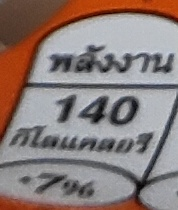

In [5]:
from google.colab.patches import cv2_imshow

# Specify the directory where your cropped images are saved
crops_dir = '/content/drive/MyDrive/SuperAI/Project/GDA/GDA-OBB/14032024/train-crops'

# Load the cropped images
cropped_images = load_cropped_images(crops_dir)

# Assuming 'cropped_images' contains your loaded images as before
if cropped_images:
    filename, image = cropped_images[0]
    print(f"Displaying {filename}")
    cv2_imshow(image)  # Use cv2_imshow instead of cv2.imshow in Colab
else:
    print("No cropped images were loaded.")

In [6]:
len(cropped_images)

318

## Rotate/Skew

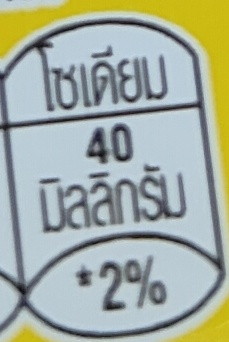

In [47]:
filename, img = cropped_images[30]
cv2_imshow(img)

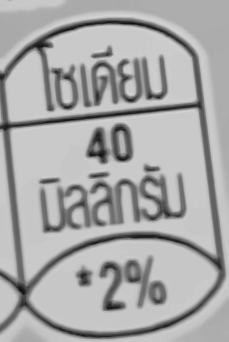

In [48]:
# grayscale
def img2gray(img):
    img = cv2.fastNlMeansDenoisingColored(img, None, 5, 5, 7, 21)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray

gray = img2gray(img)
cv2_imshow(gray)

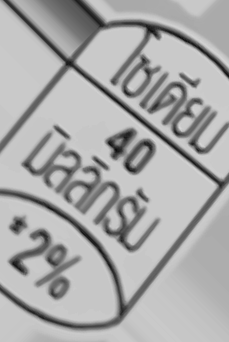

In [58]:
from deskew import determine_skew
# Deskew image
def deskew(img):
    angle = determine_skew(img)
    return rotateImage(img, angle)

# Rotate the image around its center
def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage

deskew_img = deskew(gray)
cv2_imshow(deskew_img)

---

# OCR part

In [9]:
! pip install -q pytesseract
! apt install -qq tesseract-ocr tesseract-ocr-tha
!pip install deskew
!pip install easyocr

The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd tesseract-ocr-tha
0 upgraded, 4 newly installed, 0 to remove and 38 not upgraded.
Need to get 5,715 kB of archives.
After this operation, 16.7 MB of additional disk space will be used.
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 121752 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-eng_1%3a4.00~git30-7274cfa-1.1_all.deb ...
Unpacking tesseract-ocr-eng (1:4.00~git30-7274cfa-1.1) ...
Selecting previously unselected package tesseract-ocr-osd.
Preparing to unpack .../tesseract-ocr-osd_1%3a4.00~git30-7274cfa-1.1_all.deb ...
Unpacking tesseract-ocr-osd (1:4.00~git30-7274cfa-1.1) ...
Selecting previously unselected package tesseract-ocr.
Preparing to unpack .../tesseract-ocr_4.1.1-2.1build1_amd64.deb ...
Unpacking tesseract-ocr (4.1.1-2

In [57]:
import pytesseract
def img2text(img):
    text = pytesseract.image_to_string(img, lang='tha+en', config='--psm 6') # config='--oem 3 --psm 6')
    return text

# text = img2text(gray)
text = img2text(deskew_img)
text

'\x0c'